(1001, 6) (6, 1001)
(1001, 6) (6, 1001)


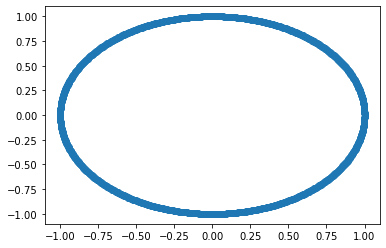

In [20]:
#!/usr/bin/env python
# coding: utf-8

# In[141]:


#!/usr/bin/env python
# coding: utf-8
from __future__ import print_function




import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lin
import quadrotor
import math



robot = quadrotor.Quadrotor()
horizon_length = 1000
N = 1000
u_ = robot.mass*robot.g/2
z0 = np.array([1,0,0,0,0,0]).reshape([6,])
u0 = u_ * np.ones([2,1])
o = (2*math.pi/10)
r = 1
T = 10


x_desired = [math.cos(o*(T/N)*i) for i in range(0,N+1)]
y_desired = [r*math.sin(o*(T/N)*i) for i in range(0,N+1)]
vx_desired = [-r*o*math.sin(o*(T/N)*i) for i in range(0,N+1)]
vy_desired = [ r*o*math.cos(o*(T/N)*i) for i in range(0,N+1)]
theta_desried = [0 for i in range(0,N+1)]
omega_desried = [0 for i in range(0,N+1)]

# v = 1/10
# v= v
# x_desired = [v*i*T/(N) for i in range(0,N+1)]
# y_desired = [v*i*T/(N) for i in range(0,N+1)]
# vx_desired = [v for i in range(0,N+1)]
# vy_desired = [v for i in range(0,N+1)]
# theta_desried = [0 for i in range(0,N+1)]
# omega_desried = [0 for i in range(0,N+1)]



state_desired = np.array([x_desired,vx_desired,y_desired,vy_desired,theta_desried,omega_desried])
ref_traj = state_desired.T
print(ref_traj.shape,state_desired.shape)




# x=np.linspace(0,2*math.pi,horizon_length+1)
# z_bar=np.zeros([6,horizon_length+1])
# z_bar[0,:]=np.cos(x)
# z_bar[1,:]=-np.sin(x)
# z_bar[2,:]=np.sin(x)
# z_bar[3,:]=np.cos(x)
# ref_traj = z_bar.T
# state_desired = z_bar




z0 = np.zeros_like(state_desired[:,0])
u_init = [(robot.mass * robot.g / 2) * np.ones([2]) for _ in range(horizon_length)]
print(ref_traj.shape,state_desired.shape)

plt.figure()
plt.scatter(x_desired,y_desired)

plt.show()



# In[142]:


In [24]:



import pylqr
import solver
try:
    import jax.numpy as np
except ImportError:
    import numpy as np



class LQR_Track_Controller:
    def __init__(self,R,dt,use_autograd = False):
        self.aux = None
        self.R_ = R
        self.dt_ = dt

        #desired functions for plant dynamics and cost
        self.plant_dyn_ = None
        self.plant_dyn_dx_ = None
        self.plant_dyn_du_ = None

        self.cost_ = None
        self.cost_dx_ = None
        self.cost_du_ = None
        self.cost_dxx_ = None
        self.cost_duu_ = None
        self.cost_dux_ = None

        self.lqr_ = None

        self.use_autograd=use_autograd
        return

    def build_LQR_tracking(self,ref_pnts, weight_mats,obj):
        #obj must have next_state,  get_linearization
        self.obj = obj
        #figure out dimension
        self.T_ = len(ref_pnts)# leave the last point alone


        self.ref_array = np.copy(ref_pnts)
        self.weight_array = [mat for mat in weight_mats]
        #clone weight mats if there are not enough weight mats
        for i in range(self.T_ - len(self.weight_array)):
            self.weight_array.append(self.weight_array[-1])


        def tmp_cost_func(x, u, t, aux):
            err = x[0:self.obj.nu] - self.ref_array[t]
            #autograd does not allow A.dot(B)
            cost = np.dot(np.dot(err, self.weight_array[t]), err) + np.sum(u**2) * self.R_
            return cost

        self.cost_ = tmp_cost_func
        self.lqr_ = solver.Solver(T=self.T_ - 1, plant_dyn=self.plant_dyn_, cost=self.cost_,
                                  use_autograd=self.use_autograd)
        if not self.use_autograd:
            self.plant_dyn = lambda x, u, t, aux:obj.next_state(x,u,t)
            self.plant_dyn_du_ = lambda x, u, t, aux: obj.get_linearization(x, u, t)[0]
            self.plant_dyn_dx_ = lambda x, u, t, aux: obj.get_linearization(x, u, t)[1]
            def tmp_cost_func_dx(x, u, t, aux):
                err = x - self.ref_array[t]
                grad = np.concatenate([2 * err.dot(self.weight_array[t])])
                return grad

            self.cost_dx_ = tmp_cost_func_dx

            self.cost_du_ = lambda x, u, t, aux: 2 * self.R_ * u

            def tmp_cost_func_dxx(x, u, t, aux):
                hessian = np.zeros((self.obj.ns,self.obj.ns))
                hessian = 2 * self.weight_array[t]
                return hessian

            self.cost_dxx_ = tmp_cost_func_dxx

            self.cost_duu_ = lambda x, u, t, aux: 2 * self.R_ * np.eye(self.obj.nu)
            self.cost_dux_ = lambda x, u, t, aux: np.zeros((self.obj.nu,self.obj.ns))

            # build an iLQR solver based on given functions...
            self.lqr_.plant_dyn = self.plant_dyn
            self.lqr_.plant_dyn_dx = self.plant_dyn_dx_
            self.lqr_.plant_dyn_du = self.plant_dyn_du_
            self.lqr_.cost_dx = self.cost_dx_
            self.lqr_.cost_du = self.cost_du_
            self.lqr_.cost_dxx = self.cost_dxx_
            self.lqr_.cost_duu = self.cost_duu_
            self.lqr_.cost_dux = self.cost_dux_
        return

    def synthesize_trajectory(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.lqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(self.obj.nu) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(self.obj.ns)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.lqr_.LQR_solve(x_init,u_init)
        x_star = res_dict['x_array_star']
        Ks = res_dict['K_array_opt']
        ks = res_dict['k_array_opt']
        x_array_new, u_array_new = self.apply_control(x_star, u_init, ks, Ks,alpha=1)
        return x_array_new[:, 0:self.obj.nu]

    def get_rule(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.lqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(self.obj.nu) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(self.obj.ns)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.lqr_.LQR_solve(x_init,u_init)
        x_star = res_dict['x_array_star']
        Ks = res_dict['K_array_opt']
        ks = res_dict['k_array_opt']
        return Ks,ks

    def controller(self,u,x,k_array,K_array):
        pass

    def apply_control(self, x_array, u_array, k_array, K_array,alpha=1) :
        x_new_array = [None] * len(x_array)
        u_new_array = [None] * len(u_array)
        x_new_array[0] = x_array[0]
        for t in range(self.T_ -1 ):
            u_new_array[t] = u_array[t] + alpha * (k_array[t] + K_array[t].dot(x_new_array[t]-x_array[t]))
            x_new_array[t+1] = self.obj.next_state(x_new_array[t], u_new_array[t], t)
        return np.array(x_new_array), np.array(u_new_array)






In [25]:
%%time
weight_mats = [np.diag([60,20,10,10,5,5]) * 100]


def lqr_controller(state,i):
    lqr_traj_ctrl = LQR_Track_Controller(R=1.01, dt=0.01)
    lqr_traj_ctrl.build_LQR_tracking(ref_traj[i:], weight_mats, robot)
    Ks, ks = lqr_traj_ctrl.get_rule(state, u_init[i:])
    ut = Ks[0].dot(state-state_desired[:,i]) + ks[0] + u_init[0]
    return ut.T


t, state, u = robot.simulate(z0,lqr_controller, horizon_length, disturbance = False)



Wall time: 49 s


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAUGFtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA5AZYiEABD//veBvzLL
XyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuH+4x2xPbAAAArgAVwJEflNQL71nT4ADkMV
VPbRK84RdyqRUb6gRRR3eFQvVE+KTOH603JMImy4IeauYGfkC5QJLIc84ErblKTJbTqwzR4Yl3kc
jYnKfKjcI37bKL3OEZMXCcYw2mayGHGQhOtp/ofbg//2++sGGRgJage3e3p1cJ4vwELvqcBAznSW
jm9uE69bPcEEqxzH/ygnG5lvIJO+RlkrK5ov90C+x3bm7Xz9n0QP81UWNLKjMf/+cP8Q14GSLecc
3Qb3Z/bHAcKOzxcjgUlirS7g9p00645/65bQ4ExPs8dK1qfLdt2hW5uxji+7x+iOINOONMZK65Oo
PWLb/W3KU+vo8tOT0cyNawDm6wBvs2/z/KTIAB6dWpU92tYn+gUXFOE/1CnX4ERw82/bkSOdqzoA
TFozMmD0v7r+aHJiIdmu+A2opuXi2MyoR2+7r+Z3jQHe0GqpnFRoWpzahMo53qW/eQjhdiLpq5MX
6d9HxPCvn0bf4Uimk4BYwU+gNnsd2eLQ+mwN8Bd2n8XGrqePeIR3xeTig1TTUKVdBjSnlHysodh1
xFr3il0JoB1P/Tojdehn7Wk57Jrj0UhzAv9jJaqKJCs910kLWO/goo18TpeBH3OCA0bEpy5uXWiw
0op+WPAkOlXwm5wcpZsN+4pO1fqSh4A9Bbtgx7MItl4YrVuSUYxkVx+c7Ns+fOrUgkYn4li3p/fe
FPtXn4Od/ZdnweqfnsQLEhgy7Aes3/rEyzBpdaDyTcYljJl9GldM61wkVfDnuwBPhryc3QTC6epN
BQAAB+ev6Js3IkIgmWh1Uju12uamM9wD4PG1cDA65/XoIM+CnPjhkhyK4W+9mTQQb208AgW1ZlBG
KreoqtUmgTAUyYRuAcYeShIn9LzNibTQVlIOsbzPJOXEEoXEXcdOItV21cnd+HHSjLiV0/8FEs7T
UkPTnr1Mx//gCZDyaAcV/L/MFAEY/TQVZI1qZI165X9Kpnwou3s5FrROCODhlILIPOugWOEbkUNL
4jPQC7typVQEup3vyZHnV+edAyYgd/t0rJ8WRLnb3RKNa0+t2iBw7xrTZad3rnvfCOGckO/6V7t3
tL8G8OXIuz+t7KtjlYULbxFfd+WaU43VnNZ8w/im0Cc9Hz14ljZgInYZ9oo3cRgYM+aZ7AAAAwB6
IFaYZ+I6p44fTFBYRJwmsD/JDqBUHq7SnRYV/95gu7HCfCp+4uYQqfk81Z05Y8WGyZCn4yPCnGHj
wkkH/71SNfFPAYozf1Ps3cqw0bcEpH/Z+Q8TUS49hSLuc3IxHo6UIYDXvwvTHAU9MfEI0JaGlWLH
BEmywaDn6rTVG+K8YA7JhAijdu9jH/PkDfPtyeIVw4XGJcduCqDQYfvPZmRTLLI5PXp0SQYvFz6x
Sv/rCcRvqDfrWKs/4PX7+0mbBfcRsoZV6hAEL9mbsJf6myjYlpVuUIg95a+FHRnJJaoXSQpadx6h
LM+FZXC6TGYLy5W6+z3GuNeRq95wwZW2xAnxvnpKqpqnnYxEFfwhrJL591DE9Bwyi4UonDi05XiP
FFk0VeFVumrtYAABHqAAvBhltxbmRq49LYBEdVwJfDt/xffRNp76TBqfQzgdrd/ZKqJfdNArGEOv
/P/ayPdiIxjG++Z2kAmoZiPmIM3WkF2l75Q/hCxM+3l+JPESZCRIY4atguugVj9b8V+Ai5WRO5fb
WO53+gPlTmGgZEGVvjiG1MG7aStcwIBaYeixsre0cU670PN0R2QhXxgxf06e8hYoBhUouveTD9DF
d8CoBg9ioOOILxoTKW66+BSXCq2dks0FWxGcUAgVz0GNFGasWnBh669UpXjN6OTNjLPEseZnSqyd
XLX/zTwjFV0/CIUcPfGKFTmskh645bJLnC7vXAq62hWOOqfa9WKDU9GzsHlWb4L0lEf4KX4vQPn/
QgrTMGVWCJyisd4TP399MHa/QkM5HNVubZN11mnFfBTCZJyp73oNFUbZ8113exAPLMw8X9Ml+q11
f4oKZYef/NRG6j/3LS0BEQM6txnU5sVejY0eYAMPgXmgC8Fi/+ajnTIIq/GTz+b0nbDUkL6kTY/3
9pUWrknQE9tqkhVn882sLMBldS780H1wmp1jB35V+bs6rh/G9NsXiQq+GUNVuVQfhr0WCQAAWSdL
vX5zUl6otb0AiF7yZPah/WJmeMFxNrSwAAm298XuKInVPtLIC+55gPoO1Th06I110veb+NORl4/8
zHV8ExxFa60FYILwCo/M92wq+fiPIvcGxyDsf821hi63mspQQH7jn5mdDPQJv1INoMYKoDI2Zazz
AtchwGm+RWDadaPEQ2TNFeq4XwWf/wtdIuuZpwtJ43bF8Ndq6jQpgHgKkak28aDApyIY0z/90Zkx
MDjmKrmT86rt7DS/Oz9JLphY/6ajI3HTo74jpu+LzczzPETMWB4hAKCCiq7x0zgNVo1Qs0K8OmP/
bdqvueXpLrg24H/cnyVl/Ih3TMmh/Z7we8xkVdCODGWCI8cc1yU/XJCYh3VTZMnom6iPNoucr/0w
t8NZR9ibjSYfTkPvxDnFPx9hfPXNIxF1XKClaRggF0V6xyR4gADjrdvcE4wAAlpBbnS3EsJ7nN/5
DsRX6DyhM3Wwr2Djjig5YjlzxBD08yEUE9jBjX/F9TQOuPZ/X5l1aCDJB2s8xlUOOFoXaEUM5l1C
ts8O7drQtKjDz43E+wfrT1KEKB7RFVzZtQ4QdCvPJNxkfrRyqYyFW0ZdP4jp64yQqv7j/xxJN//C
wx3QCj+8FL8XnEnYXaL0k7y+cg9XYKYT9UDeQzkdFF5Zeuds9Dm4Mk67vRqKHfMkYjWFpbevpLW+
klaCrZoafe/j4IW9y/PgI

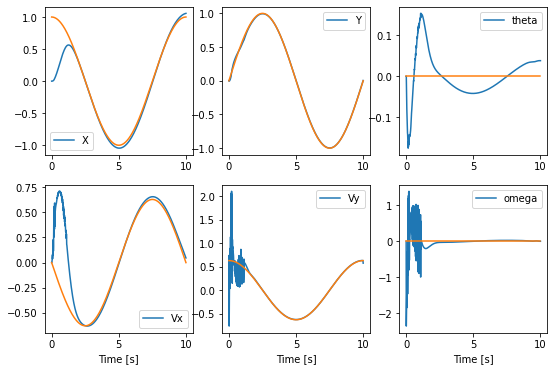

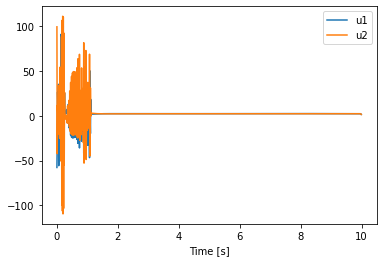

In [26]:

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_desired[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_desired[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_desired[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_desired[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_desired[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_desired[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')
robot.animate_robot(state,u)